

      Input --> LLM
      LLM --> Feedback
      Feedback --> LLM

In [ ]:
## create a llm model
import os
from dotenv import load_dotenv
load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
from langchain_groq import ChatGroq
llm = ChatGroq(model="gemma2-9b-it")
llm

In [15]:
from typing_extensions import Literal, TypedDict, Annotated
from pydantic import BaseModel, Field

class State(TypedDict):
      topic: str
      feedback: str
      joke: str
      funny_or_not: str

# schema for structured otput to use in evaluation
class Feedback(BaseModel):
      grade: Literal["funny", "not funny"] = Field(description="funny or not funny",)
      feedback: str = Field(description="if the joke is not funny provide feedback on the joke",)

evaluator = llm.with_structured_output(Feedback)
# evaluator = llm.with_structured_output(Feedback, state=State)

In [13]:
def llm_call_genrator(state: State):
    """
    This function genrate joke on the topic
    """
    if state.get("feedback"):
      msg = llm.invoke(f"Generate a joke on the topic {state['topic']} considering  the feedback is {state['feedback']}")
    else:
      msg = llm.invoke(f"Generate a joke on the topic {state['topic']}")
    return {"joke": msg.content}


In [16]:
def llm_call_evaluator(state: State):
    """
    This function evalute the joke
    """
    msg = llm.invoke(f"Grade the joke {state['joke']} on the topic {state['topic']}")
    return {"funny_or_not":grade.grade, "feedback":msg.content}

In [17]:
def route_joke(state: State):
    """
    This function route the joke to the llm
    """
    if state["funny_or_not"] == "not funny":
      return "Rejected + Feedback"
    elif state["funny_or_not"] == "funny":
      return "Accepted"

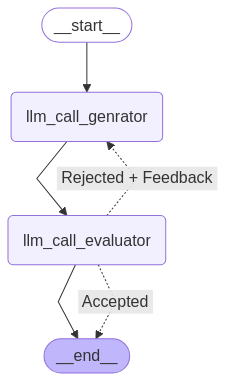

In [27]:
#Build Workflow
from langgraph.graph import StateGraph,START,END


optimizer_builder = StateGraph(State)

optimizer_builder.add_node("llm_call_genrator", llm_call_genrator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {  # Name returned by route_joke : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "llm_call_genrator",
    },

)
optimizer_builder.add_edge(START, "llm_call_genrator")
optimizer_builder.add_edge("llm_call_genrator", "llm_call_evaluator")
optimizer_builder.add_edge("llm_call_evaluator", END)


optimizer_builder.compile()